In [173]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import notebook
import pandas as pd

import BB_DL
from utils import compute_stats, get_grad
from MB_LBFGS import LBFGS

In [124]:
import matplotlib.style as style
style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batch_size = 64
overlap_ratio = 0.25  # for LBFGS
max_iter = 20

In [25]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

torch.Size([64, 1, 28, 28])
torch.Size([64])


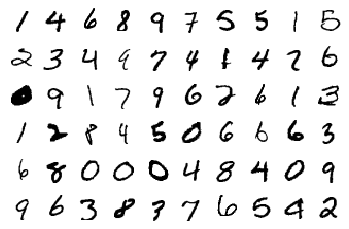

In [26]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [27]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)


In [28]:
optimizers = [
    'SGD',
    'SGD with momentum',
    'Adam',
    'BB'   
]

In [29]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images).cpu() #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss


In [87]:
def train(model, train_loader, optimizer, epoch, opt_name, criterion):
    running_loss = 0.
    model.train()
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("{}: Epoch {} - Training loss: {}".format(opt_name,
                                                    epoch,
                                                    running_loss/len(train_loader)))
    return running_loss/len(train_loader)


def test(model, test_loader, criterion, epoch, opt_name):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.shape[0], -1)
            output = model(images)
            test_loss += criterion(output, labels).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('{}: Epoch {} - Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(opt_name,
                                                                                            epoch,
                                                                                            test_loss,
                                                                                            correct,
                                                                                            len(test_loader.dataset),
                                                                                            100. * correct / len(test_loader.dataset)))
    
    return test_loss, 100. * correct / len(test_loader.dataset)

In [88]:
train_losses = {}
val_losses = {}
val_accs = {}
times = {}

for opt_name in optimizers:
    
    input_size = 784
    hidden_sizes = [128, 64]
    output_size = 10

    model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.ReLU(),
                          nn.Linear(hidden_sizes[1], output_size),
                          nn.LogSoftmax(dim=1))
    
    criterion = nn.CrossEntropyLoss()

    if opt_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), 
                              lr=0.003)
        
    if opt_name == 'SGD with momentum':
        optimizer = optim.SGD(model.parameters(), 
                              lr=0.003, 
                              momentum=0.9)
        
    if opt_name == 'Adam':
        optimizer = optim.Adam(model.parameters())
        
    if opt_name == 'BB':
        optimizer = BB_DL.BB(model.parameters(), 
                             lr=0.003, 
                             steps=len(trainloader), 
                             beta=4. / len(trainloader), 
                             max_lr=1, min_lr=1e-5)
    
    
    train_losses[opt_name] = []
    val_losses[opt_name] = []
    val_accs[opt_name] = []
    
    time0 = time()
    epochs = 15
    for epoch in notebook.tqdm(range(epochs)):
        train_loss = train(model, trainloader, optimizer, epoch, opt_name, criterion)
        val_loss, val_acc = test(model, valloader, criterion, epoch, opt_name)
        
        train_losses[opt_name].append(train_loss)
        val_losses[opt_name].append(val_loss)
        val_accs[opt_name].append(val_acc)
        
    times[opt_name] = (time()-time0)/60

SGD: Epoch 0 - Training loss: 1.9470273403724883
SGD: Epoch 0 - Test set: Average loss: 1.3448, Accuracy: 7438/10000 (74%)
SGD: Epoch 1 - Training loss: 0.8805889170179998
SGD: Epoch 1 - Test set: Average loss: 0.6023, Accuracy: 8430/10000 (84%)
SGD: Epoch 2 - Training loss: 0.5332905295243395
SGD: Epoch 2 - Test set: Average loss: 0.4519, Accuracy: 8744/10000 (87%)
SGD: Epoch 3 - Training loss: 0.4383198073677925
SGD: Epoch 3 - Test set: Average loss: 0.3950, Accuracy: 8903/10000 (89%)
SGD: Epoch 4 - Training loss: 0.39366905489710097
SGD: Epoch 4 - Test set: Average loss: 0.3612, Accuracy: 8968/10000 (90%)
SGD: Epoch 5 - Training loss: 0.36686287702782067
SGD: Epoch 5 - Test set: Average loss: 0.3380, Accuracy: 9043/10000 (90%)
SGD: Epoch 6 - Training loss: 0.3473314042411633
SGD: Epoch 6 - Test set: Average loss: 0.3208, Accuracy: 9077/10000 (91%)
SGD: Epoch 7 - Training loss: 0.3320056630937911
SGD: Epoch 7 - Test set: Average loss: 0.3090, Accuracy: 9119/10000 (91%)
SGD: Epoch 8 -

SGD with momentum: Epoch 0 - Training loss: 0.6734536179124928
SGD with momentum: Epoch 0 - Test set: Average loss: 0.3207, Accuracy: 9028/10000 (90%)
SGD with momentum: Epoch 1 - Training loss: 0.28918701841601174
SGD with momentum: Epoch 1 - Test set: Average loss: 0.2344, Accuracy: 9295/10000 (93%)
SGD with momentum: Epoch 2 - Training loss: 0.22290135680564813
SGD with momentum: Epoch 2 - Test set: Average loss: 0.1967, Accuracy: 9412/10000 (94%)
SGD with momentum: Epoch 3 - Training loss: 0.17945325229642614
SGD with momentum: Epoch 3 - Test set: Average loss: 0.1678, Accuracy: 9499/10000 (95%)
SGD with momentum: Epoch 4 - Training loss: 0.1504456681538937
SGD with momentum: Epoch 4 - Test set: Average loss: 0.1442, Accuracy: 9569/10000 (96%)
SGD with momentum: Epoch 5 - Training loss: 0.12821078947834622
SGD with momentum: Epoch 5 - Test set: Average loss: 0.1284, Accuracy: 9624/10000 (96%)
SGD with momentum: Epoch 6 - Training loss: 0.11109363655748367
SGD with momentum: Epoch 6

Adam: Epoch 0 - Training loss: 0.40195819071488087
Adam: Epoch 0 - Test set: Average loss: 0.2196, Accuracy: 9328/10000 (93%)
Adam: Epoch 1 - Training loss: 0.19752110349439356
Adam: Epoch 1 - Test set: Average loss: 0.1423, Accuracy: 9568/10000 (96%)
Adam: Epoch 2 - Training loss: 0.14052368077471344
Adam: Epoch 2 - Test set: Average loss: 0.1263, Accuracy: 9584/10000 (96%)
Adam: Epoch 3 - Training loss: 0.1124281602820306
Adam: Epoch 3 - Test set: Average loss: 0.1140, Accuracy: 9642/10000 (96%)
Adam: Epoch 4 - Training loss: 0.0955752887453304
Adam: Epoch 4 - Test set: Average loss: 0.1089, Accuracy: 9659/10000 (97%)
Adam: Epoch 5 - Training loss: 0.08369523364859921
Adam: Epoch 5 - Test set: Average loss: 0.1040, Accuracy: 9681/10000 (97%)
Adam: Epoch 6 - Training loss: 0.07445564732771677
Adam: Epoch 6 - Test set: Average loss: 0.1022, Accuracy: 9688/10000 (97%)
Adam: Epoch 7 - Training loss: 0.06784912176044987
Adam: Epoch 7 - Test set: Average loss: 0.0963, Accuracy: 9700/10000 

BB: Epoch 0 - Training loss: 1.9133239126662964
BB: Epoch 0 - Test set: Average loss: 1.2878, Accuracy: 6939/10000 (69%)
BB: Epoch 1 - Training loss: 0.8927387609156464
BB: Epoch 1 - Test set: Average loss: 0.6355, Accuracy: 8367/10000 (84%)
BB: Epoch 2 - Training loss: 0.49748020598502046
BB: Epoch 2 - Test set: Average loss: 0.3986, Accuracy: 8874/10000 (89%)
BB: Epoch 3 - Training loss: 0.3745676713949963
BB: Epoch 3 - Test set: Average loss: 0.3647, Accuracy: 8914/10000 (89%)
BB: Epoch 4 - Training loss: 0.3299768489561101
BB: Epoch 4 - Test set: Average loss: 0.3067, Accuracy: 9123/10000 (91%)
BB: Epoch 5 - Training loss: 0.3018745067340733
BB: Epoch 5 - Test set: Average loss: 0.2012, Accuracy: 9408/10000 (94%)
BB: Epoch 6 - Training loss: 0.3526964470275493
BB: Epoch 6 - Test set: Average loss: 0.1804, Accuracy: 9451/10000 (95%)
BB: Epoch 7 - Training loss: 0.15262674546040006
BB: Epoch 7 - Test set: Average loss: 0.1594, Accuracy: 9486/10000 (95%)
BB: Epoch 8 - Training loss: 0

In [100]:
train_losses.pop('SGD with momentum')
val_losses.pop('SGD with momentum')
val_accs.pop('SGD with momentum')

[90.28,
 92.95,
 94.12,
 94.99,
 95.69,
 96.24,
 96.51,
 96.61,
 96.95,
 96.69,
 96.5,
 97.18,
 97.34,
 97.35,
 97.56]

In [225]:
def plot_train_losses(losses):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in losses.keys():
            plt.plot(np.arange(len(losses[opt])) + 1, losses[opt], '--o', label=opt, linewidth=7)
        plt.xticks(np.arange(len(losses['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Loss on MNIST Train set', fontsize=30)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Loss', size=24)
    plt.show()
    f.savefig("mnist_train_losses.pdf", bbox_inches='tight')


def plot_val_losses(losses):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in losses.keys():
            plt.plot(np.arange(len(losses[opt])) + 1, losses[opt], '--o' , label=opt, linewidth=7)
        plt.xticks(np.arange(len(losses['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Loss on MNIST Validation set', fontsize=30)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Loss', size=24)
    plt.show()
    f.savefig("mnist_val_losses.pdf", bbox_inches='tight')
    

def plot_val_accuracy(accs):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in accs.keys():
            plt.plot(np.arange(len(accs[opt])) + 1, accs[opt], '--o', label=opt, linewidth=7)
        plt.xticks(np.arange(len(accs['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Accuracy on MNIST Validation set', fontsize=25)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Accuracy, %', size=24)
    plt.show()
    f.savefig("mnist_val_accuracy.pdf", bbox_inches='tight')


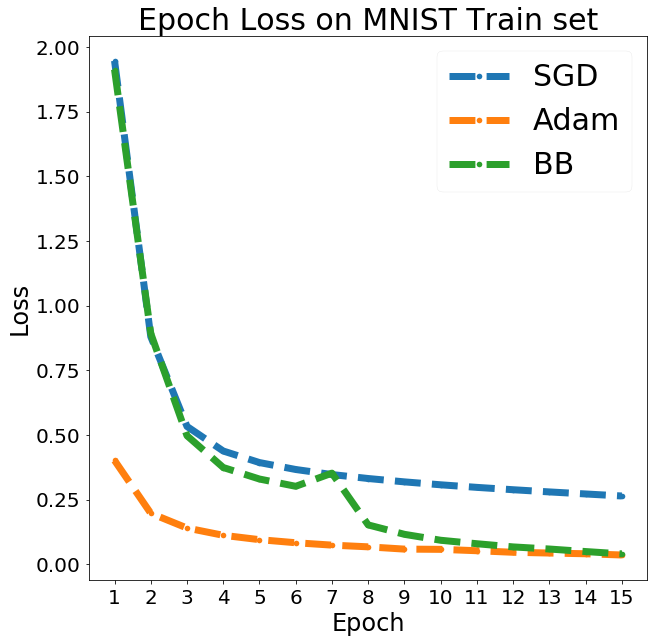

In [226]:
plot_train_losses(train_losses)

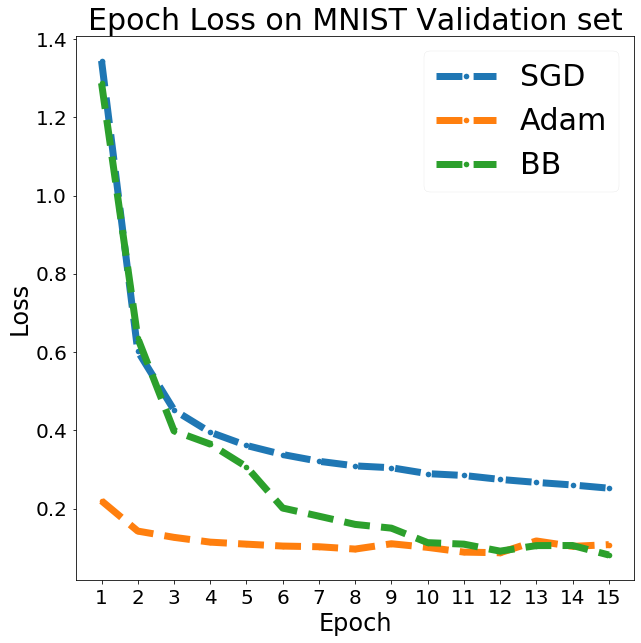

In [227]:
plot_val_losses(val_losses)

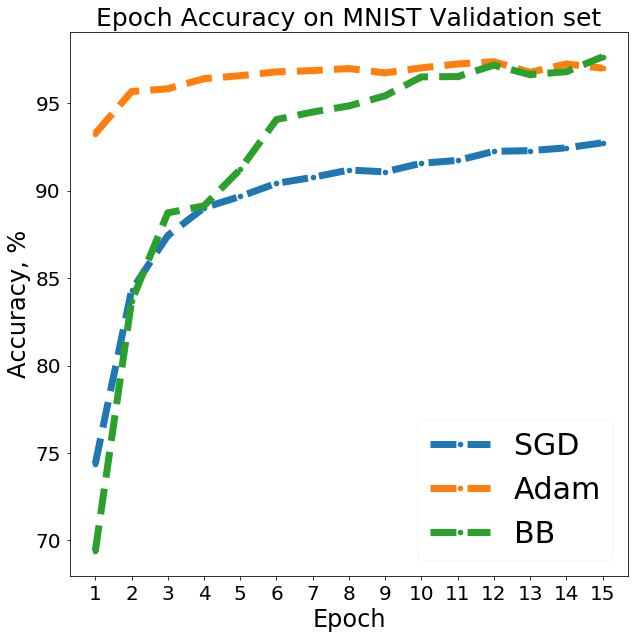

In [228]:
plot_val_accuracy(val_accs)

In [229]:
times.pop('SGD with momentum')

KeyError: 'SGD with momentum'

In [191]:
t = pd.DataFrame()
t['Optimizer'] = times.keys()
t['Time'] = times.values()
t['Acc 5'] = np.array(list(val_accs.values()))[:,4]
t['Acc 10'] = np.array(list(val_accs.values()))[:,9]
t['Acc 15'] = np.array(list(val_accs.values()))[:,14]

In [192]:
t

,Optimizer,Time,Acc 5,Acc 10,Acc 15
0,SGD,2.650769,89.68,91.58,92.75
1,Adam,2.995139,96.59,97.04,97.02
2,BB,2.746143,91.23,96.52,97.67


In [194]:
print(t.to_latex(index=False, 
                float_format="%.2f",
                multicolumn_format=True,
                multirow = True,
                multicolumn = True
                ))

TypeError: to_latex() got an unexpected keyword argument 'caption'

In [157]:
np.array(list(val_accs.values()))[:,5]

array([90.43, 96.81, 94.08])

In [15]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

Predicted Digit = 3


NameError: name 'view_classify' is not defined

In [12]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 784)
        with torch.no_grad():
            logps = model(img.cuda())

    
    ps = torch.exp(logps)
    probab = list(ps.cpu().numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
        correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 157

Model Accuracy = 0.9808917197452229


In [234]:
from torchviz import make_dot
import hiddenlayer as hl
import tensorwatch as tw

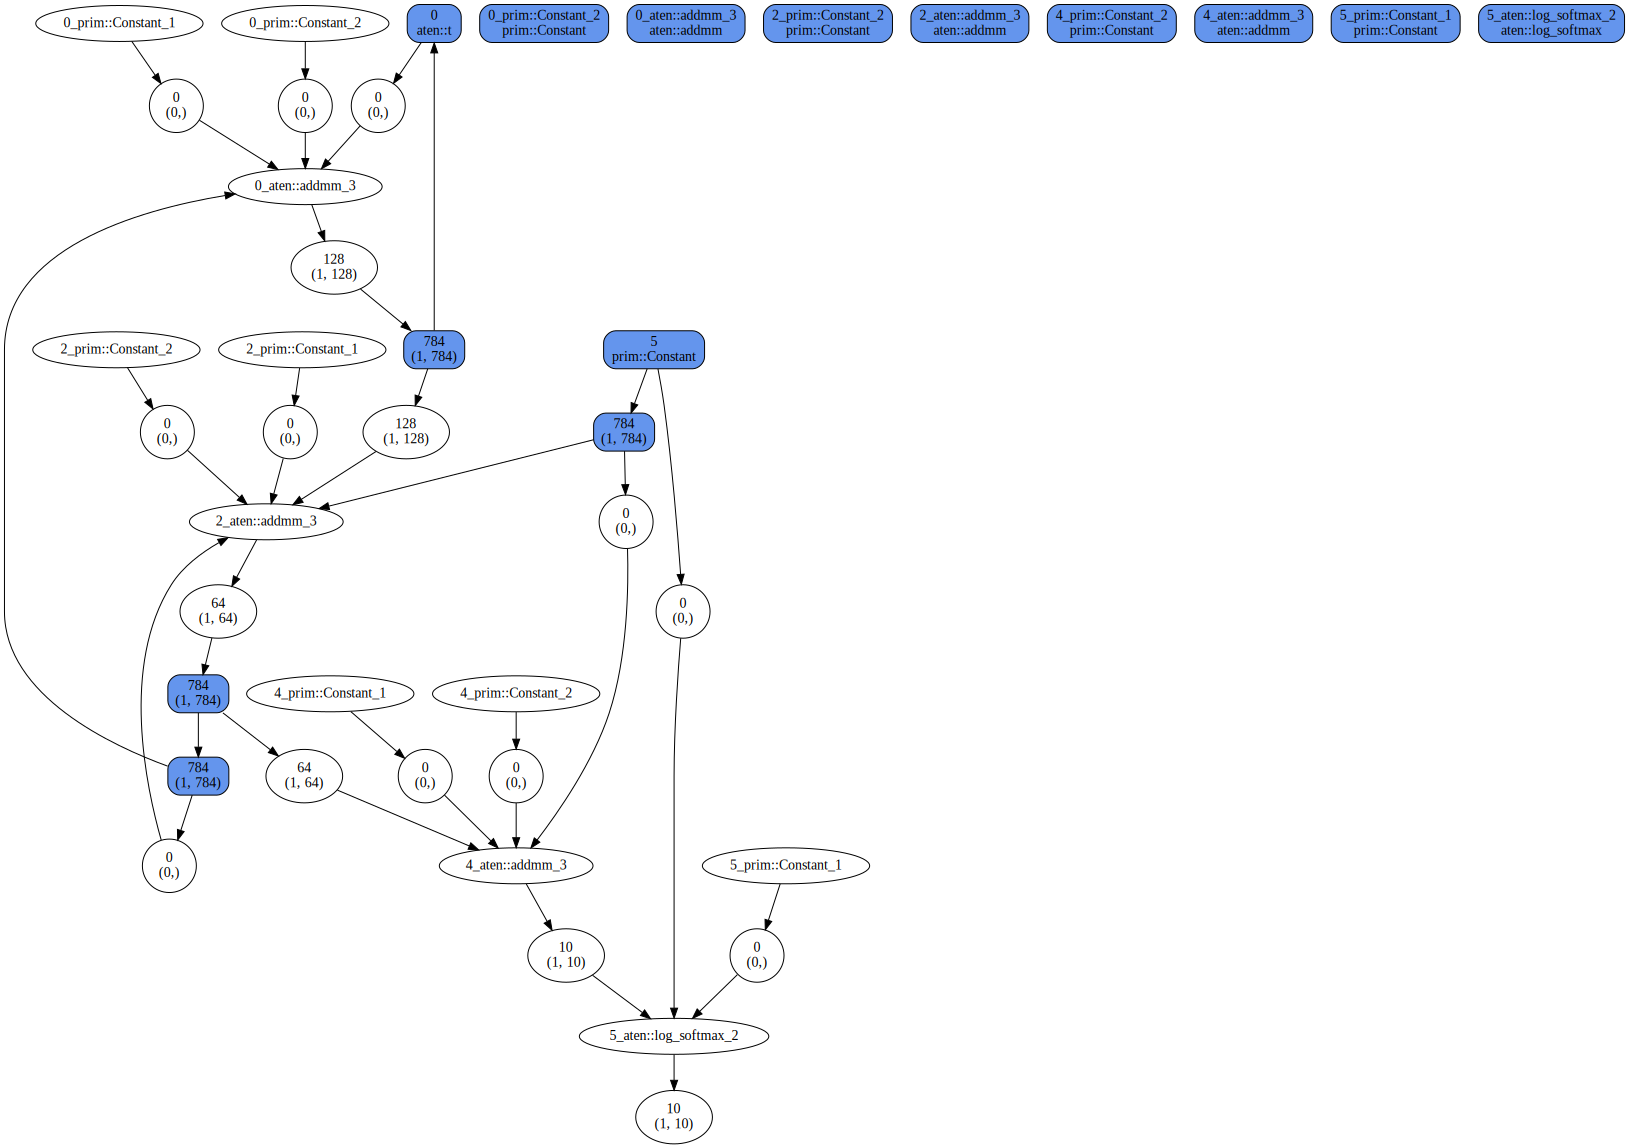

In [237]:
tw.draw_model(model, torch.zeros([1, 784]))